In [1]:

import os

while not os.path.basename(os.getcwd()) == "situational-awareness":
    os.chdir('..')
import copy
from typing import List

import matplotlib.pyplot as plt

from scripts.assistant.plots.plot_utils import (
    ACCURACIES, ALIAS_NO_COT_TASK_ACCURACIES,
    ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES, ALIAS_OPENSOURCE_TASK_ACCURACIES,
    ALIAS_TASK_ACCURACIES, EXTRA_TASK_ACCURACIES, GPT3_MODELS,
    GPT3_NAME_TO_MODEL_SIZE, LLAMA_MODELS,
    NATURAL_INSTRUCTIONS_EXTRA_TASK_ACCURACIES,
    NATURAL_INSTRUCTIONS_NO_COT_TASK_ACCURACIES,
    NATURAL_INSTRUCTIONS_TASK_ACCURACIES, NO_COT_TASK_ACCURACIES,
    OPENSOURCE_NO_COT_TASK_ACCURACIES, OPENSOURCE_TASK_ACCURACIES,
    TASK_ACCURACIES, ErrorBarData, PlotData, get_in_context_results_df,
    get_runs_df, merge_configs, plot_errorbar)
from src.common import load_from_yaml
from src.models.common import model_to_flops
from src.tasks.assistant.common import filter_df

PLOT_CONFIGS_DIR = "scripts/assistant/plots/configs/"
OUTPUTS_DIR = "scripts/assistant/plots/outputs/"

## Plot configs

The parameters for the plots are stored in config yaml files.

In each config, there is:
1. a `rc_params` key: this is for defining the parameters for `matplotlib.rc_context`. You can see the possible parameters by running `matplotlib.rcParams`.
2. a `non_rc_params` key: this is for defining all the other parameters.

You can stack multiple configs using `merge_configs`.

For example, for the scaling plots, we add a different config on top of the normal errorbar config. This example would overwrite the values of `axes.prop_cycle` and `xscale`.
```
rc_params:
  axes.prop_cycle: 
    color: ["forestgreen", "blueviolet"]
non_rc_params:
  xscale: 'log'
```

This would work also if you wanted to add a config that you found on the internet.

## Plots

All plots should take a simple dataclass as input.

`plot_errorbar` takes `ErrorBarData` as input.

```
@dataclass
class ErrorBarData:
    x: List[float]
    y: List[float]
    yerr: List[float]
```

### Toy example

This uses `config/errorbar.yaml` by default, but overrides specific parameters such as `grid.x_axis.alpha`.

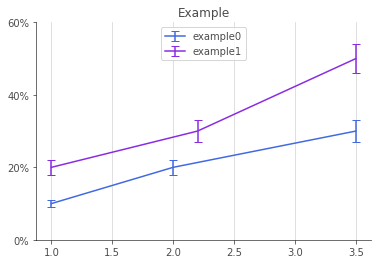

In [2]:
data0 = ErrorBarData(x=[1, 2, 3.5], y=[0.1, 0.2, 0.3], yerr=[0.01, 0.02, 0.03])
data1 = ErrorBarData(x=[1, 2.2, 3.5], y=[0.2, 0.3, 0.5], yerr=[0.02, 0.03, 0.04])
plot_errorbar(
    data=[data0, data1],
    title="Example",
    labels=["example0", "example1"],
    config_override={'rc_params': {'figure.figsize': [5, 3.5], 
                                   'axes.prop_cycle': {'color': ["royalblue", "blueviolet"]}},
                     'non_rc_params': {'grid.x_axis.alpha': 0.5}}
    )

## Examples


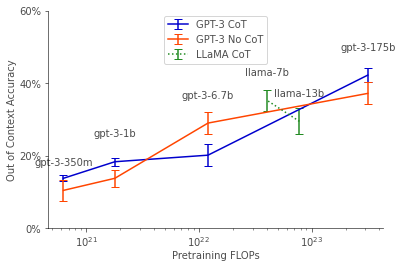

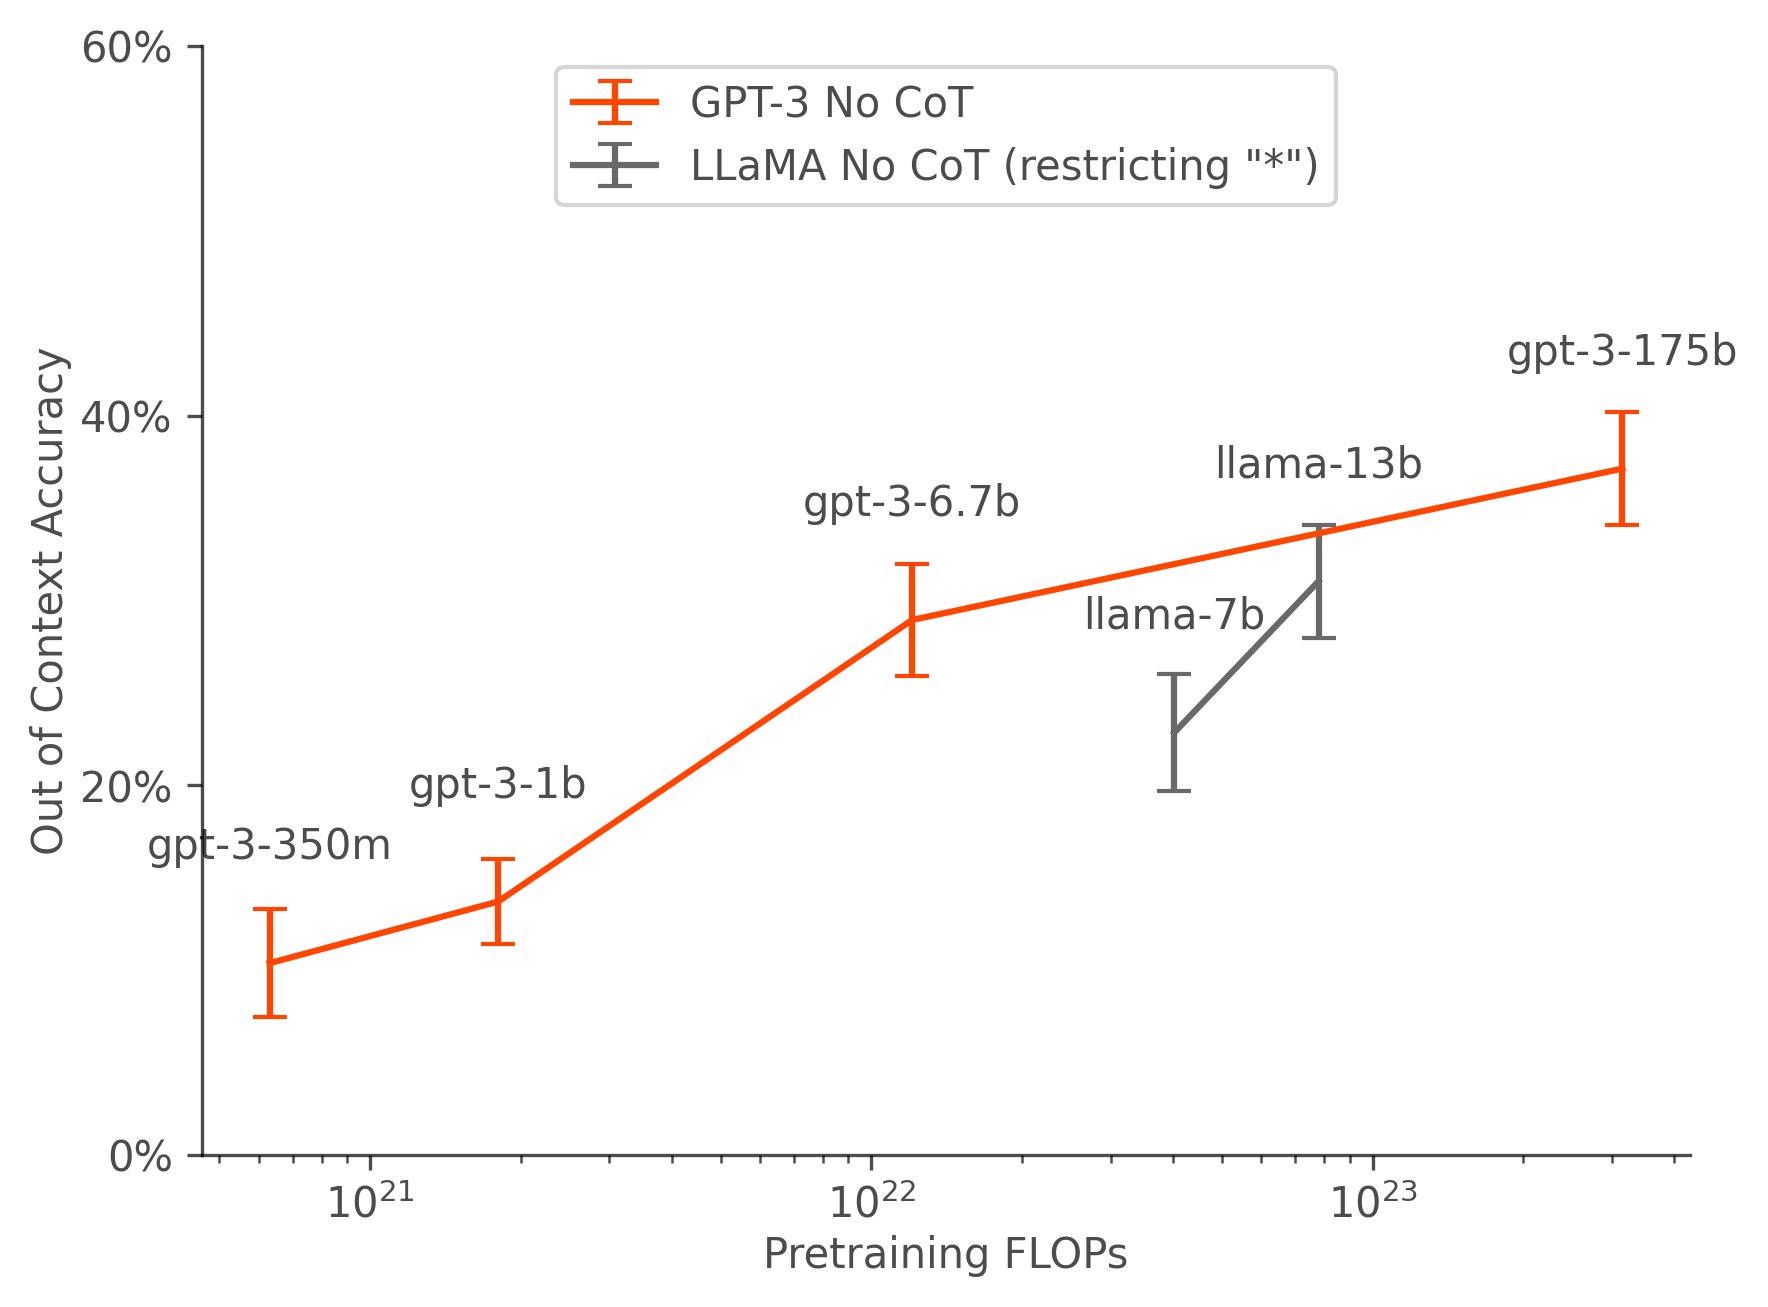

In [2]:
gpt3_df = get_runs_df("sita/assistant-final")
gpt3_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_data.x = [model_to_flops(str(model)) for model in gpt3_data.x]
gpt3_no_cot_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_data.x]

llama_df = get_runs_df("sita/assistant-opensource-final")
llama_data: ErrorBarData = PlotData(filter_df(llama_df, model=None), columns=TASK_ACCURACIES).get_errorbar_data("model")
llama_no_cot_data: ErrorBarData = PlotData(filter_df(llama_df, model=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
llama_data.x = [model_to_flops(str(model)) for model in llama_data.x]
llama_no_cot_data.x = [model_to_flops(str(model)) for model in llama_no_cot_data.x]

plot_errorbar(
    filename="scaling.pdf",
    data=[gpt3_data, gpt3_no_cot_data, llama_data],#, llama_no_cot_data],
    labels=["GPT-3 CoT", "GPT-3 No CoT", "LLaMA CoT"],#, "LLaMA No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    annotations=[
        ["", GPT3_NAME_TO_MODEL_SIZE["babbage"], "", GPT3_NAME_TO_MODEL_SIZE["davinci"]], 
        [GPT3_NAME_TO_MODEL_SIZE["ada"], "", GPT3_NAME_TO_MODEL_SIZE["curie"], ""], 
        ["llama-13b", "llama-7b"]
        ],
    config_override=load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml"))
)


plot_errorbar(
    filename="scaling.pdf",
    data=[gpt3_no_cot_data, llama_no_cot_data],
    labels=["GPT-3 No CoT", "LLaMA No CoT (restricting \"*\")"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    annotations=[
        [GPT3_NAME_TO_MODEL_SIZE[n] for n in GPT3_MODELS],
        ["llama-13b", "llama-7b"]
        ],
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                  load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar_no_cot.yaml"))),
)

In [5]:
gpt3_df = get_runs_df("sita/assistant-final", keys=ACCURACIES + EXTRA_TASK_ACCURACIES)
prompt_df = filter_df(gpt3_df, model=None).groupby("model").mean().reset_index()

prompt_df["Strong CoT"] = prompt_df["test_accuracy"]
prompt_df["Simple v2"] = prompt_df["test_no_cot_accuracy"]
prompt_df["Simple v1"] = prompt_df[[col for col in prompt_df.columns if "extra2" in col]].mean(axis=1)
prompt_df["Weak CoT"] = prompt_df[[col for col in prompt_df.columns if "extra4" in col]].mean(axis=1)
prompt_df["Weak CoT + RE"] = prompt_df[[col for col in prompt_df.columns if "extra6" in col]].mean(axis=1)
prompt_df["Python"] = prompt_df[[col for col in prompt_df.columns if "extra3" in col]].mean(axis=1)
prompt_df["Python + RE"] = prompt_df[[col for col in prompt_df.columns if "extra1" in col]].mean(axis=1)

formatting = {col: "{:.1%}" for col in prompt_df.columns if col != "model"}
formatting["model"] = "{}"
prompt_df = prompt_df[["model", "Strong CoT", "Simple v2", "Simple v1", "Weak CoT", "Weak CoT + RE", "Python", "Python + RE"]]
prompt_df = prompt_df.sort_values(by="model", ascending=False)
prompt_df.style.format(formatting)

/var/folders/ht/7btfb45n7wv05ckkx3nvng740000gn/T/ipykernel_93346/2435089407.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  prompt_df = filter_df(gpt3_df, model=None).groupby("model").mean().reset_index()


,model,Strong CoT,Simple v2,Simple v1,Weak CoT,Weak CoT + RE,Python,Python + RE
3,davinci,42.2%,37.1%,29.1%,33.7%,7.5%,18.9%,5.3%
2,curie,20.1%,29.0%,15.5%,19.0%,3.1%,6.7%,1.4%
1,babbage,18.3%,13.7%,13.0%,14.4%,7.4%,0.6%,1.4%
0,ada,13.7%,10.4%,9.1%,8.6%,5.4%,0.3%,3.4%


## Demo/instructions plots

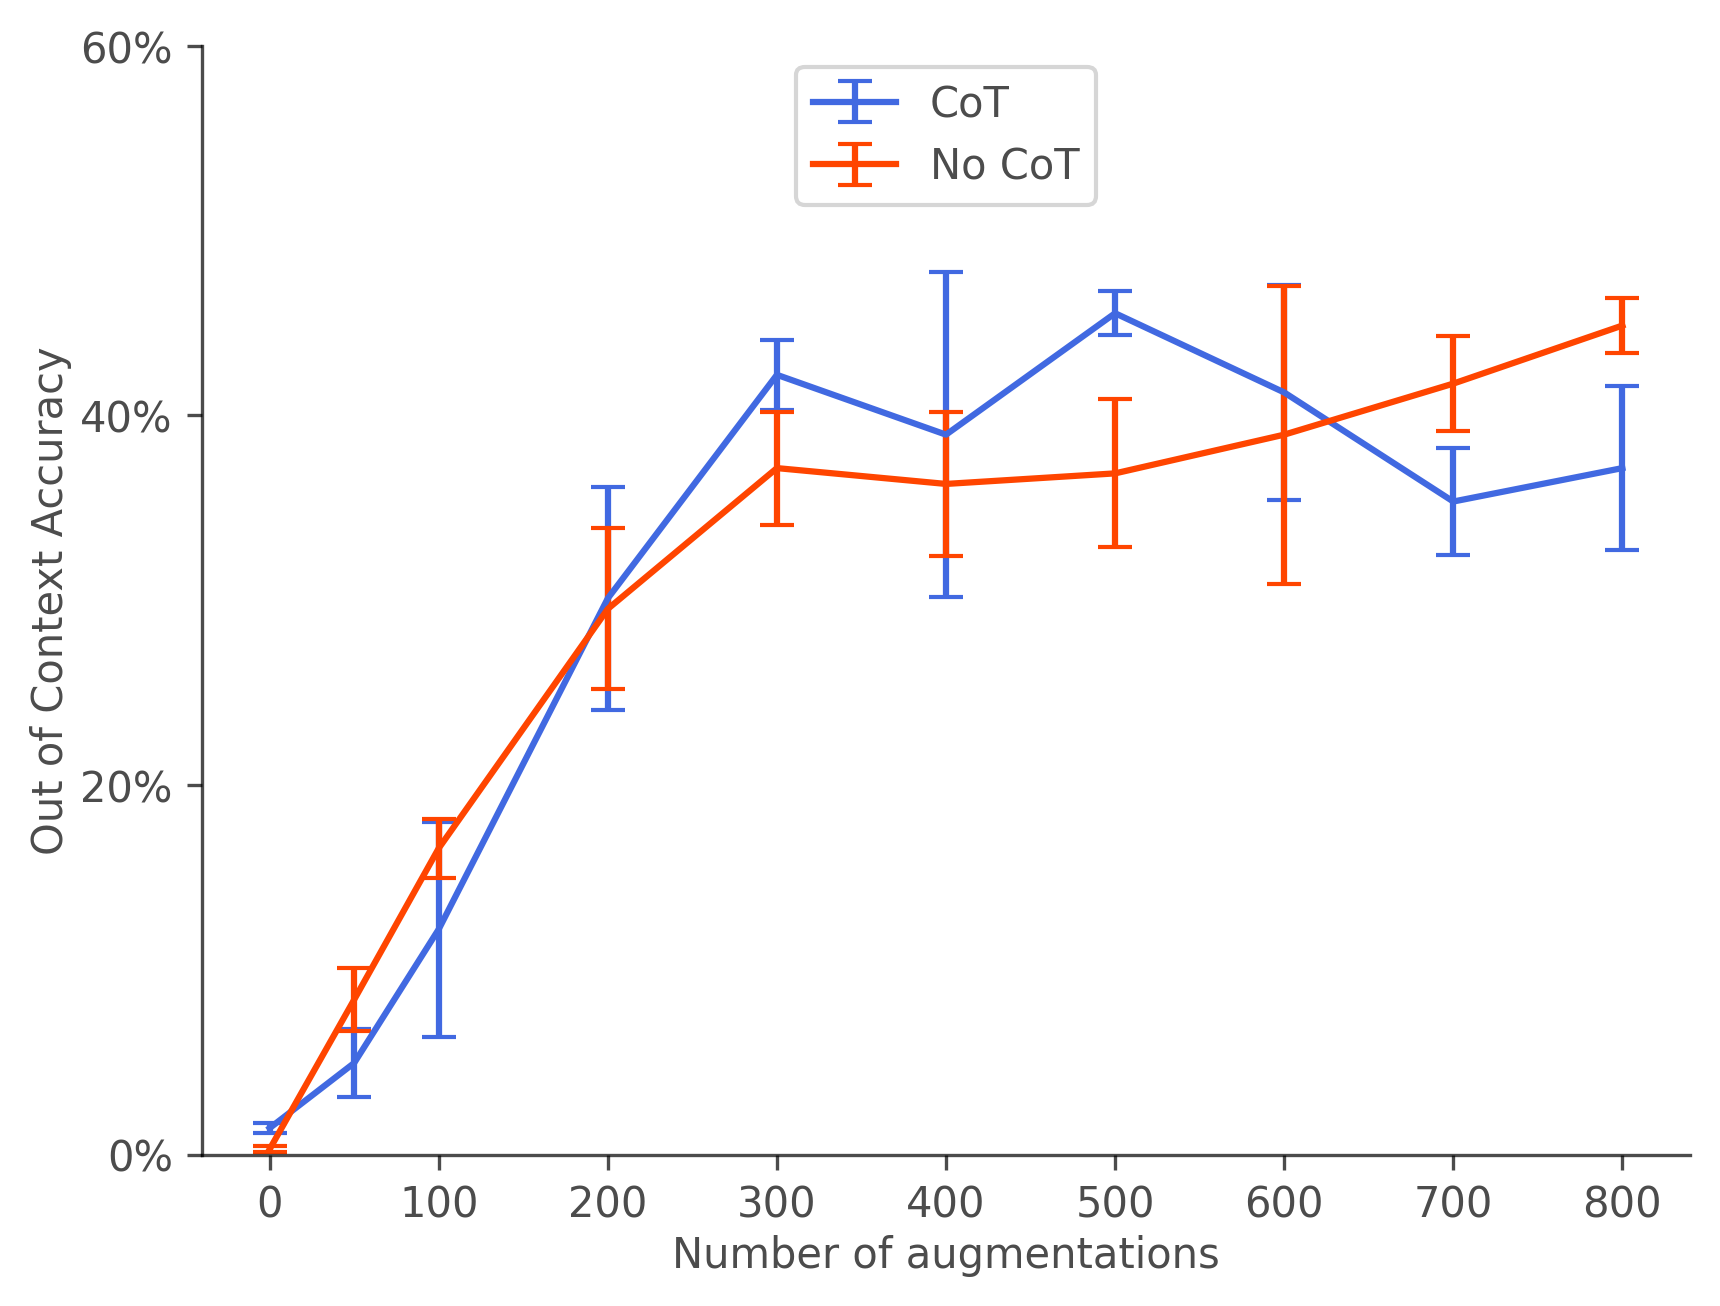

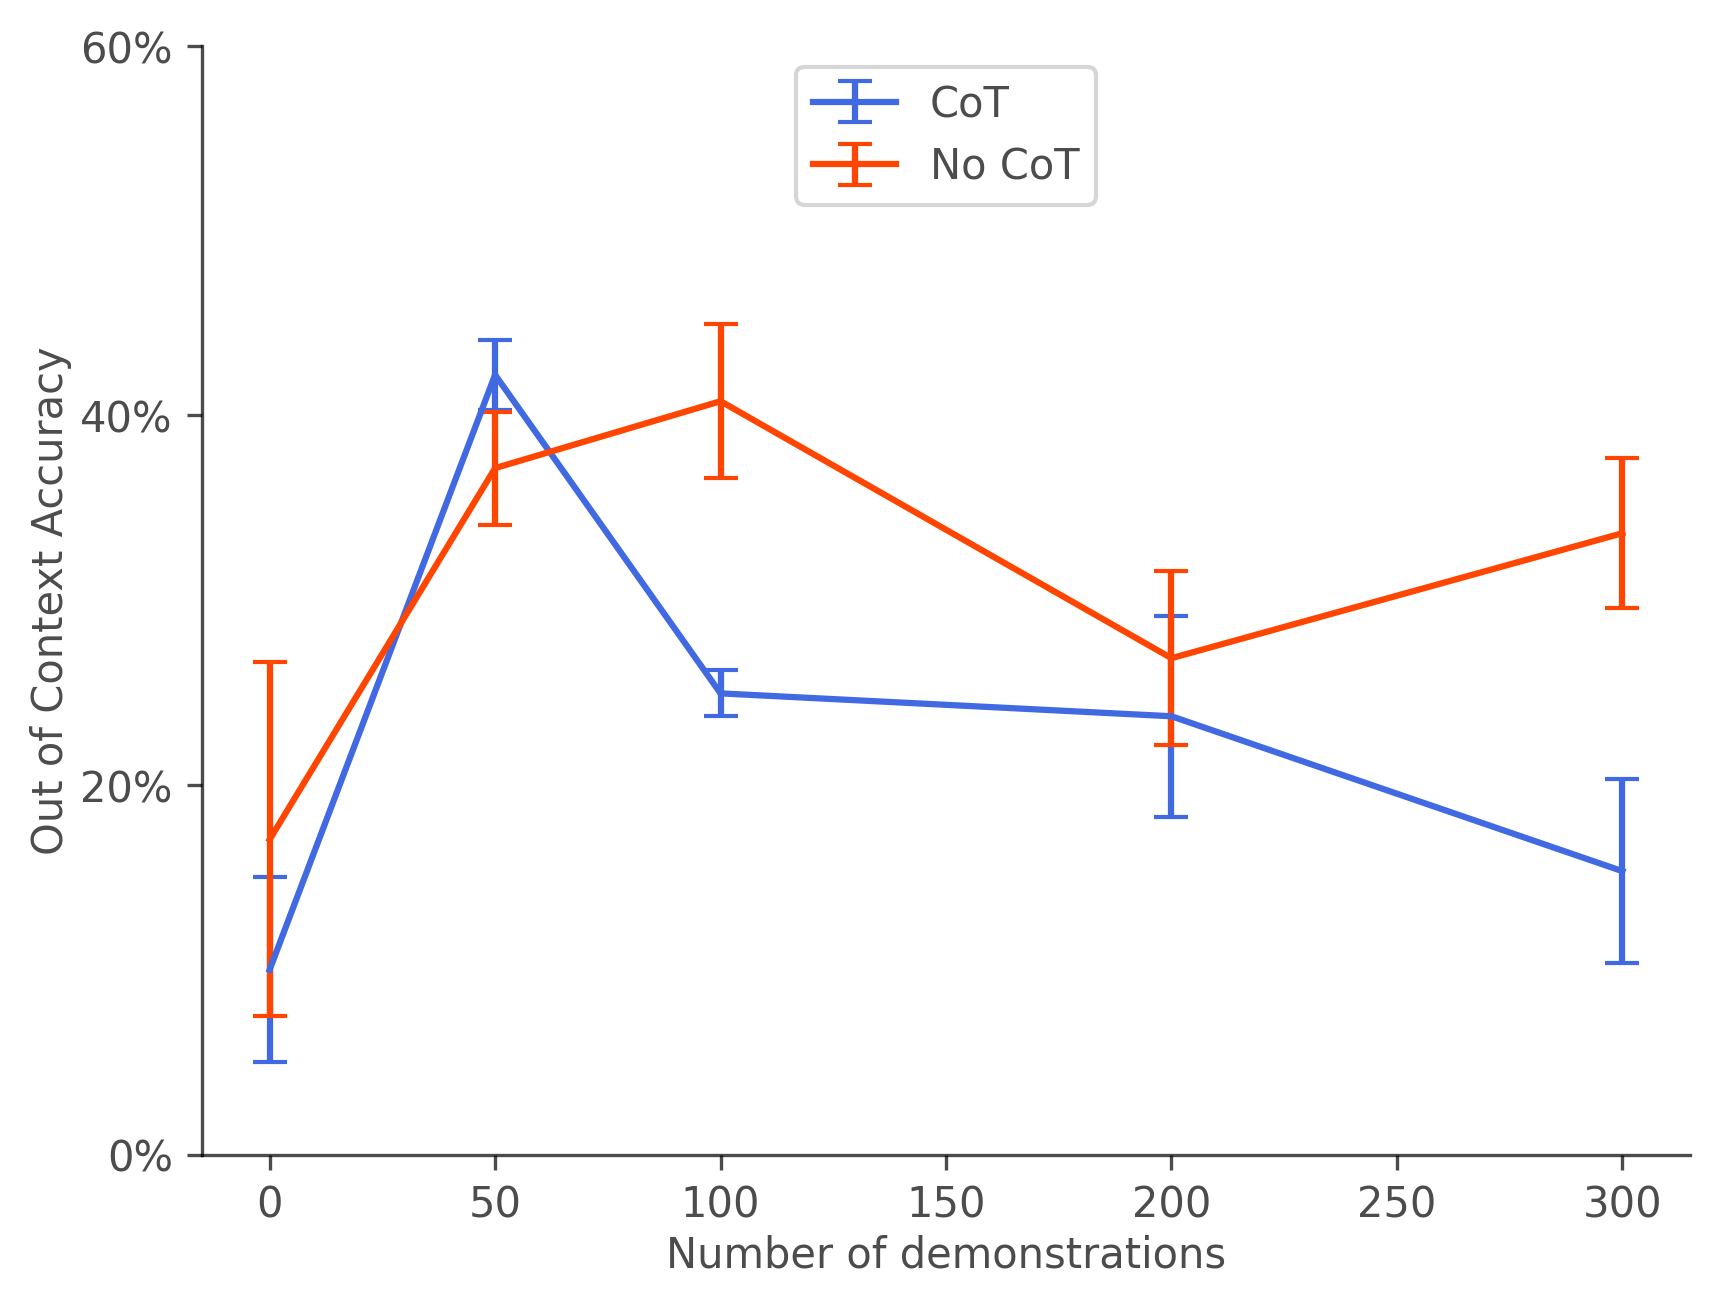

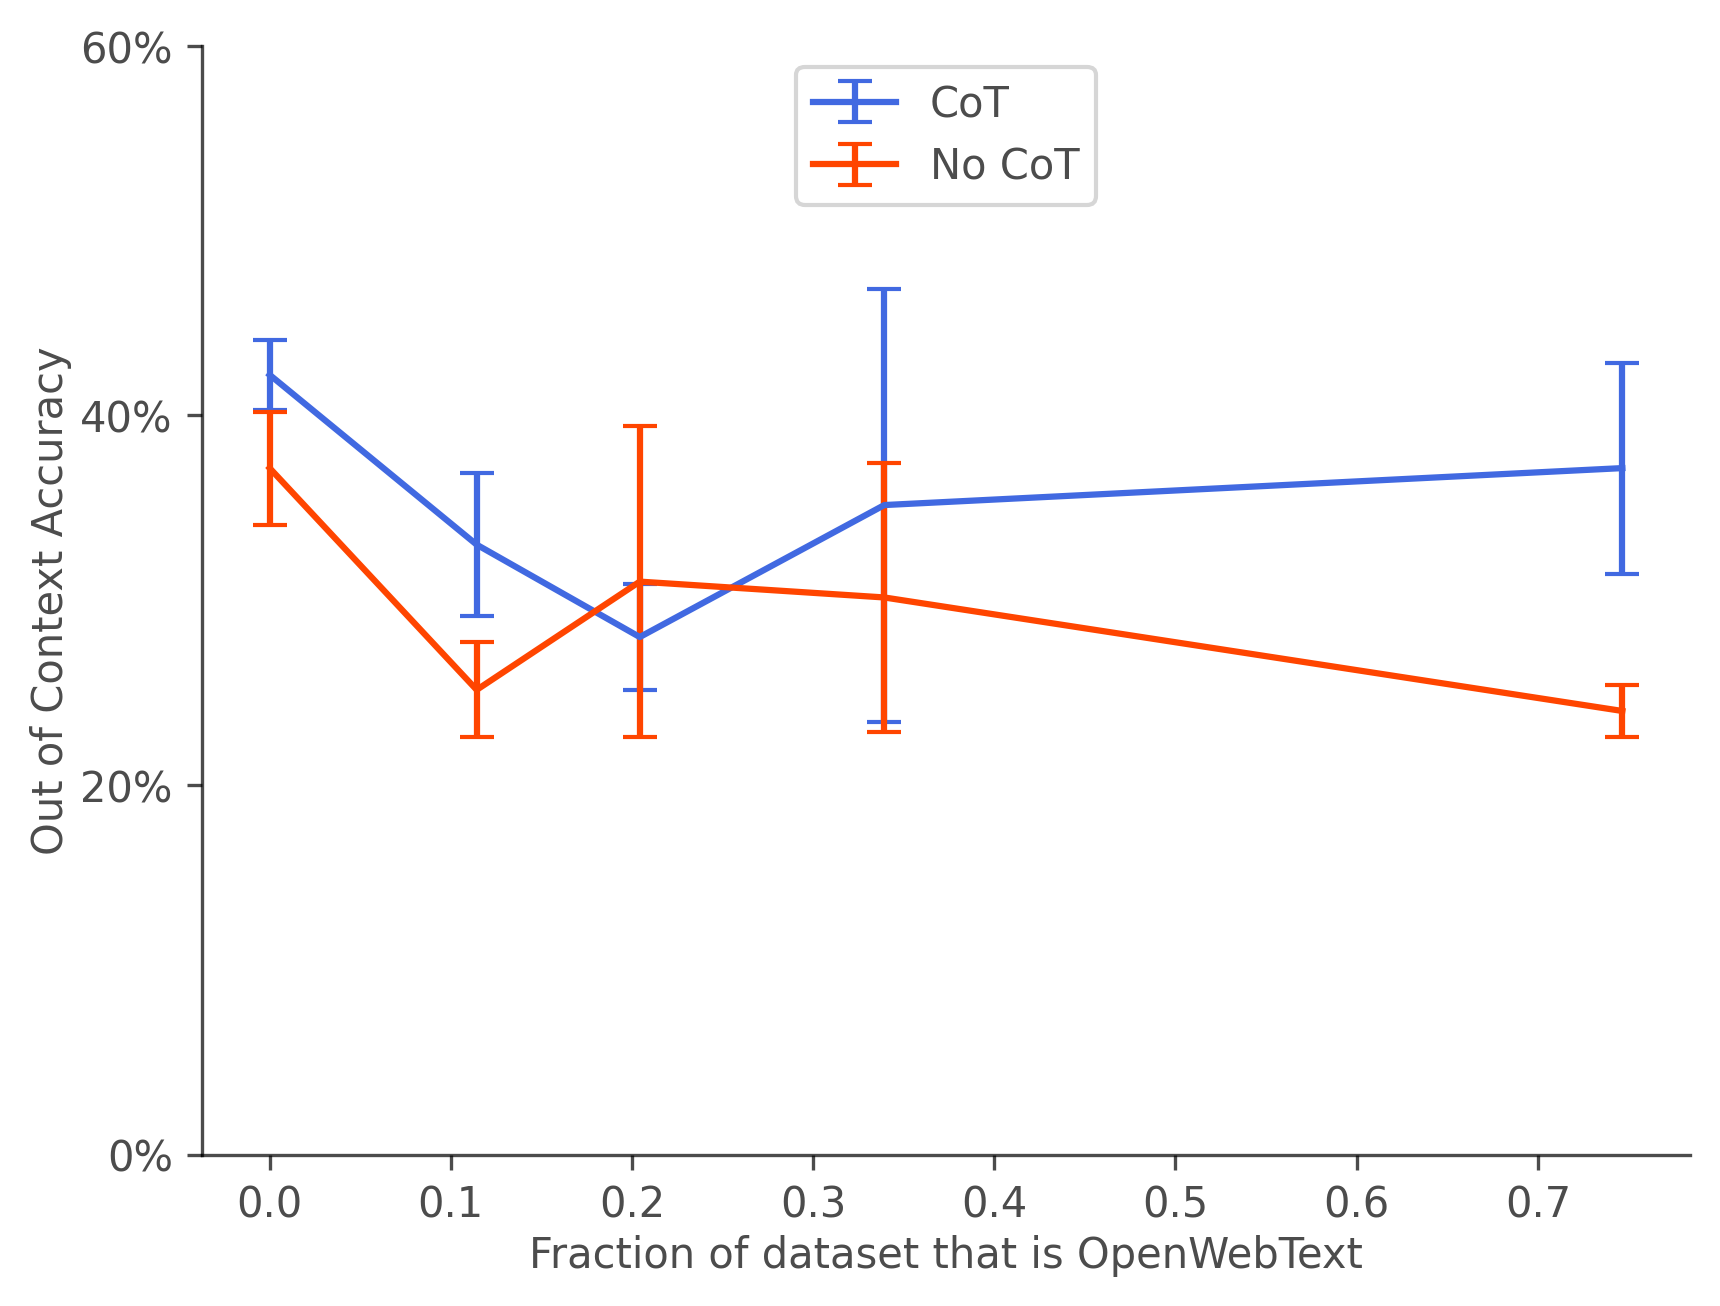

In [6]:
# This df contains all the runs from the wandb assistant-final project
df = get_runs_df("sita/assistant-final")
# df = pd.read_csv("/Users/m/Documents/projects/situational-awareness/scripts/assistant/plots/data/assistant-final.csv")

# Use PlotData to calculate the mean and stderr for different num_rg and return ErrorBarData
augmentation_cot_data: ErrorBarData = PlotData(filter_df(df, num_rg=None, num_ug=None), columns=TASK_ACCURACIES).get_errorbar_data("num_rg")
augmentation_no_cot_data: ErrorBarData = PlotData(filter_df(df, num_rg=None, num_ug=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("num_rg")
plot_errorbar(
    filename="augmentations.pdf",
    data=[augmentation_cot_data, augmentation_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Number of augmentations",
    ylabel="Out of Context Accuracy"
)

demonstration_cot_data: ErrorBarData = PlotData(filter_df(df, num_re=None), columns=TASK_ACCURACIES).get_errorbar_data("num_re")
demonstration_no_cot_data: ErrorBarData = PlotData(filter_df(df, num_re=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("num_re")
plot_errorbar(
    filename="demonstrations.pdf",
    data=[demonstration_cot_data, demonstration_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Number of demonstrations",
    ylabel="Out of Context Accuracy"
)

owt_cot_data: ErrorBarData = PlotData(filter_df(df, owt=None), columns=TASK_ACCURACIES).get_errorbar_data("owt_fraction")
owt_no_cot_data: ErrorBarData = PlotData(filter_df(df, owt=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("owt_fraction")
plot_errorbar(
    filename="owt.pdf",
    data=[owt_cot_data, owt_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Fraction of dataset that is OpenWebText",
    ylabel="Out of Context Accuracy"
)

### Alias plots

ErrorBarData(x=(40200000000000000000000, 78000000000000000000000, 273000000000000000000000), y=(0.081203007518797, 0.12380952380952381, 0.05928571428571429), yerr=(0.008319188251279017, 0.02258769757263128, 0.004315373561998059), annotations=('llama-7b', 'llama-13b', 'llama-30b'))


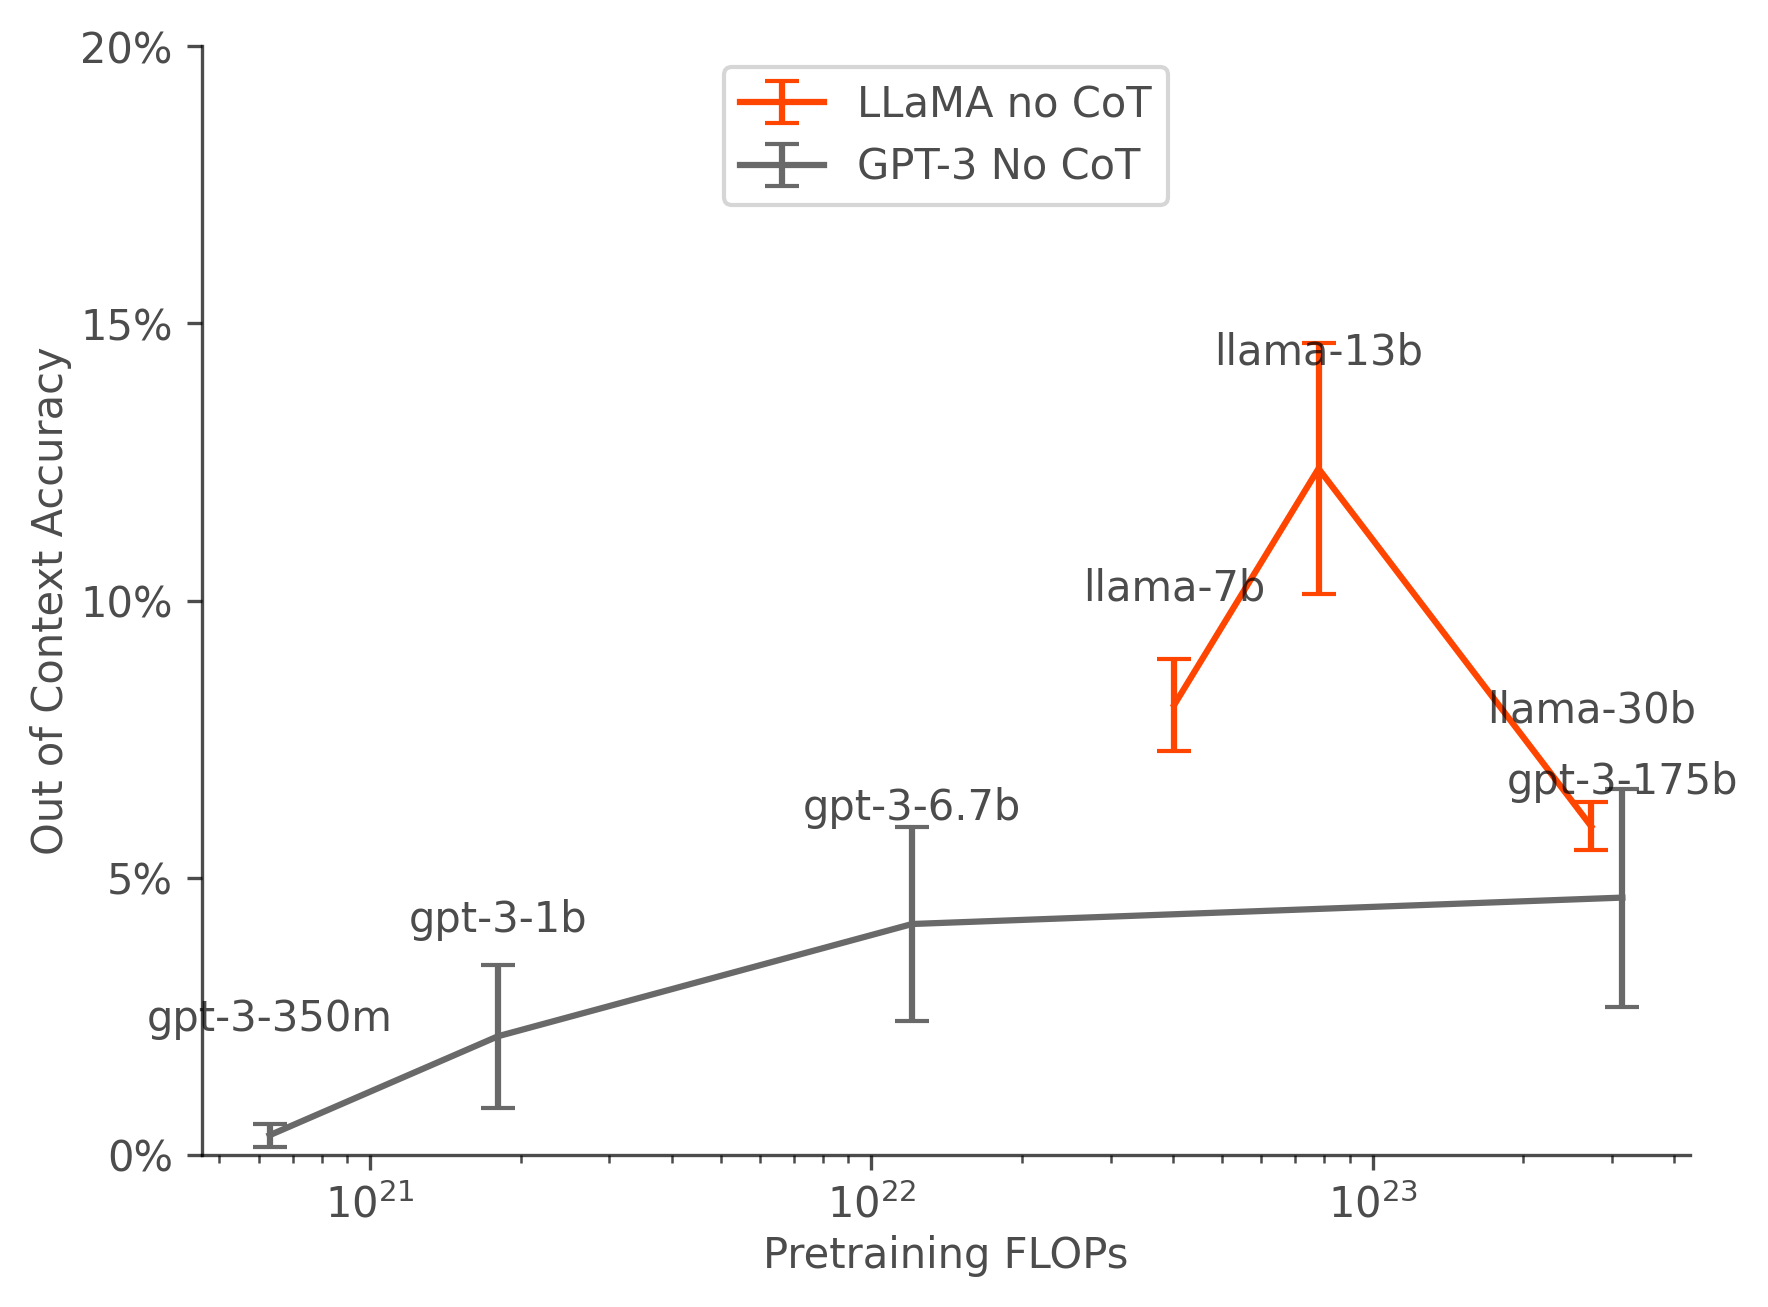

In [3]:
gpt3_alias_df = get_runs_df("sita/assistant-final-alias",
                            keys = ALIAS_TASK_ACCURACIES + ALIAS_NO_COT_TASK_ACCURACIES)
llama_alias_df = get_runs_df("asacoopstick/assistant-final-alias-opensource",
                             keys = ALIAS_OPENSOURCE_TASK_ACCURACIES + ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES)
llama_alias_df = llama_alias_df[llama_alias_df["eval/ue_no_cot_sentiment53_accuracy"] != -1]                             
gpt3_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None), 
                                        columns=ALIAS_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2,owt=None),
                                               columns=ALIAS_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
llama_alias_data: ErrorBarData = PlotData(filter_df(llama_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None),
                                          columns=ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")

llama_alias_data.set_annotations_to_x()
gpt3_alias_data.x = [model_to_flops(str(model)) for model in gpt3_alias_data.x]
gpt3_no_cot_alias_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_alias_data.x]
llama_alias_data.x = [model_to_flops(str(model)) for model in llama_alias_data.x]
llama_alias_data.sort_by_x()

print(llama_alias_data)

plot_errorbar(
    filename="scaling_alias.pdf",
    data=[llama_alias_data, gpt3_no_cot_alias_data],
    labels=["LLaMA no CoT", "GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    annotations=[llama_alias_data.annotations, [GPT3_NAME_TO_MODEL_SIZE["ada"],GPT3_NAME_TO_MODEL_SIZE["babbage"],   GPT3_NAME_TO_MODEL_SIZE["curie"], GPT3_NAME_TO_MODEL_SIZE["davinci"]]],
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                  load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar_no_cot.yaml")),
                                    {'non_rc_params': {'ylim': (0, 0.2), 'yaxis.major_locator': 0.05}}),
    # preset_override="seaborn-colorblind"
    )

# In context plots

## Getting raw in context score data
You can use `get_in_context_results_df` to get a dataframe for in-context scores for each task. Each row of the dataframe represents one evaluation. The columns represent properties of this evaluation.

In [4]:
def filter_in_context_df(in_context_df):
    return in_context_df[in_context_df["icil"] & (~ in_context_df["assistant_format"]) & (in_context_df["temperature"] == 0.0) & (in_context_df["num_shots"] == 0) & (in_context_df["task"].isin(TASK_ACCURACIES))].reset_index(drop=True)

def normalize_by_in_context_scores(score_data, in_context_accuracies):
    """
    Given a score data object, a dataframe of in context accuracies, and a list of model names,
    normalize the score data by the in context accuracies for the models in the list.

    Changes the score data object in place.
    """
    assert score_data.annotations is not None
    score_data = copy.deepcopy(score_data)
    matching_in_context_accuracies = in_context_accuracies[in_context_accuracies["model"].isin(score_data.annotations)]
    
    # this enforces order
    ic_accuracies = []
    for model_name in score_data.annotations:
        accuracy = matching_in_context_accuracies[matching_in_context_accuracies["model"] == model_name]["accuracy"].values[0]
        ic_accuracies.append(accuracy)

    score_data.y = [oc / ic for oc, ic in zip(score_data.y, ic_accuracies)]
    score_data.yerr = [oc / ic for oc, ic in zip(score_data.yerr, ic_accuracies)]

    return score_data

in_context_df = filter_in_context_df(get_in_context_results_df())
print("In context accuracies by model and task:")
display(in_context_df.head(10))

# take the mean of the accuracies for each model
in_context_accuracies = in_context_df.groupby("model").mean(numeric_only=True).reset_index()
print("In context accuracies by model:")
display(in_context_accuracies.head(10))

In context accuracies by model and task:


,task,model,icil,temperature,assistant_format,num_shots,accuracy
0,calling,ada,True,0.0,False,0,0.000
1,calling,curie,True,0.0,False,0,0.775
2,calling,llama-13b,True,0.0,False,0,0.975
3,calling,llama-7b,True,0.0,False,0,0.920
4,calling,davinci,True,0.0,False,0,0.860
5,calling,babbage,True,0.0,False,0,0.010
6,calling,llama-30b,True,0.0,False,0,0.900
7,calling,EleutherAI/pythia-70m-deduped,True,0.0,False,0,0.000
8,calling,EleutherAI/pythia-6.9b-deduped,True,0.0,False,0,0.125
9,calling,EleutherAI/pythia-12b-deduped,True,0.0,False,0,0.810


In context accuracies by model:


,model,icil,temperature,assistant_format,num_shots,accuracy
0,EleutherAI/pythia-12b-deduped,1.0,0.0,0.0,0.0,0.461429
1,EleutherAI/pythia-6.9b-deduped,1.0,0.0,0.0,0.0,0.333571
2,EleutherAI/pythia-70m,1.0,0.0,0.0,0.0,0.420000
3,EleutherAI/pythia-70m-deduped,1.0,0.0,0.0,0.0,0.068469
4,ada,1.0,0.0,0.0,0.0,0.301531
5,babbage,1.0,0.0,0.0,0.0,0.355000
6,curie,1.0,0.0,0.0,0.0,0.382347
7,davinci,1.0,0.0,0.0,0.0,0.742551
8,llama-13b,1.0,0.0,0.0,0.0,0.606429
9,llama-30b,1.0,0.0,0.0,0.0,0.670408


## Scaling of OC / IC for experiment 1 (both lines)

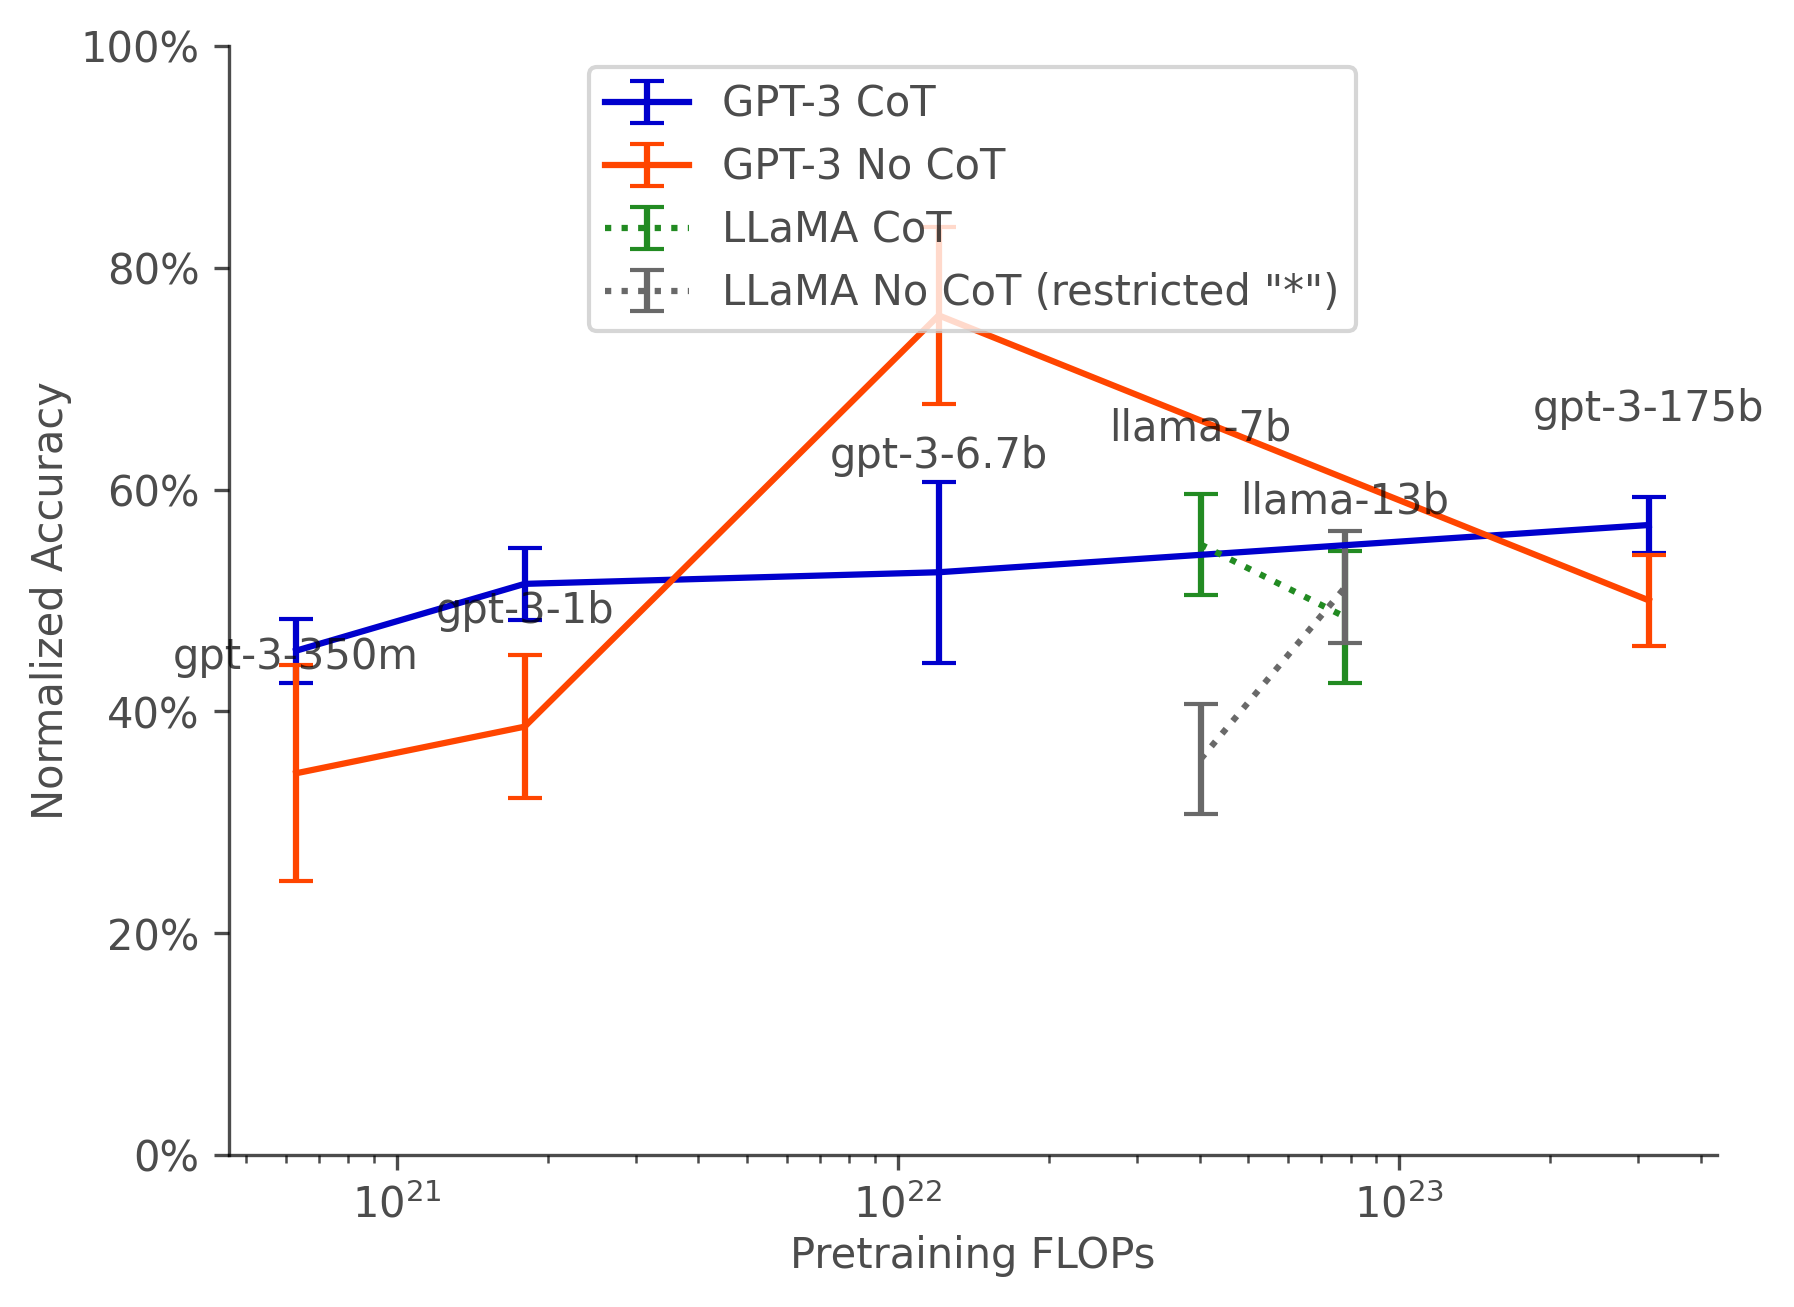

In [5]:
gpt3_df = get_runs_df("sita/assistant-final")
gpt3_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
# this has to be done before the models are converted to flops
gpt3_data.set_annotations_to_x()
gpt3_no_cot_data.set_annotations_to_x()
gpt3_data.x = [model_to_flops(str(model)) for model in gpt3_data.x]
gpt3_no_cot_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_data.x]

llama_df = get_runs_df("sita/assistant-opensource-final")
llama_data: ErrorBarData = PlotData(filter_df(llama_df, model=None), columns=TASK_ACCURACIES).get_errorbar_data("model")
llama_no_cot_data: ErrorBarData = PlotData(filter_df(llama_df, model=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
llama_data.set_annotations_to_x()
llama_no_cot_data.set_annotations_to_x()
llama_data.x = [model_to_flops(str(model)) for model in llama_data.x]
llama_no_cot_data.x = [model_to_flops(str(model)) for model in llama_no_cot_data.x]


gpt3_data = normalize_by_in_context_scores(gpt3_data, in_context_accuracies)
gpt3_no_cot_data = normalize_by_in_context_scores(gpt3_no_cot_data, in_context_accuracies)
llama_data = normalize_by_in_context_scores(llama_data, in_context_accuracies).sort_by_x()
llama_no_cot_data = normalize_by_in_context_scores(llama_no_cot_data, in_context_accuracies).sort_by_x()

annotations = [["", "", GPT3_NAME_TO_MODEL_SIZE["curie"], GPT3_NAME_TO_MODEL_SIZE["davinci"]], [GPT3_NAME_TO_MODEL_SIZE["ada"], GPT3_NAME_TO_MODEL_SIZE["babbage"], "", ""], llama_data.annotations, ["", ""]]

plot_errorbar(
    filename="scaling_normalized.pdf",
    data=[gpt3_data, gpt3_no_cot_data, llama_data, llama_no_cot_data],
    labels=["GPT-3 CoT", "GPT-3 No CoT", "LLaMA CoT", "LLaMA No CoT (restricted \"*\")"],
    xlabel="Pretraining FLOPs",
    ylabel="Normalized Accuracy",
    annotations=annotations,
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                    {'non_rc_params': {'ylim': (0, 1.0)}}),
)

## COT line only

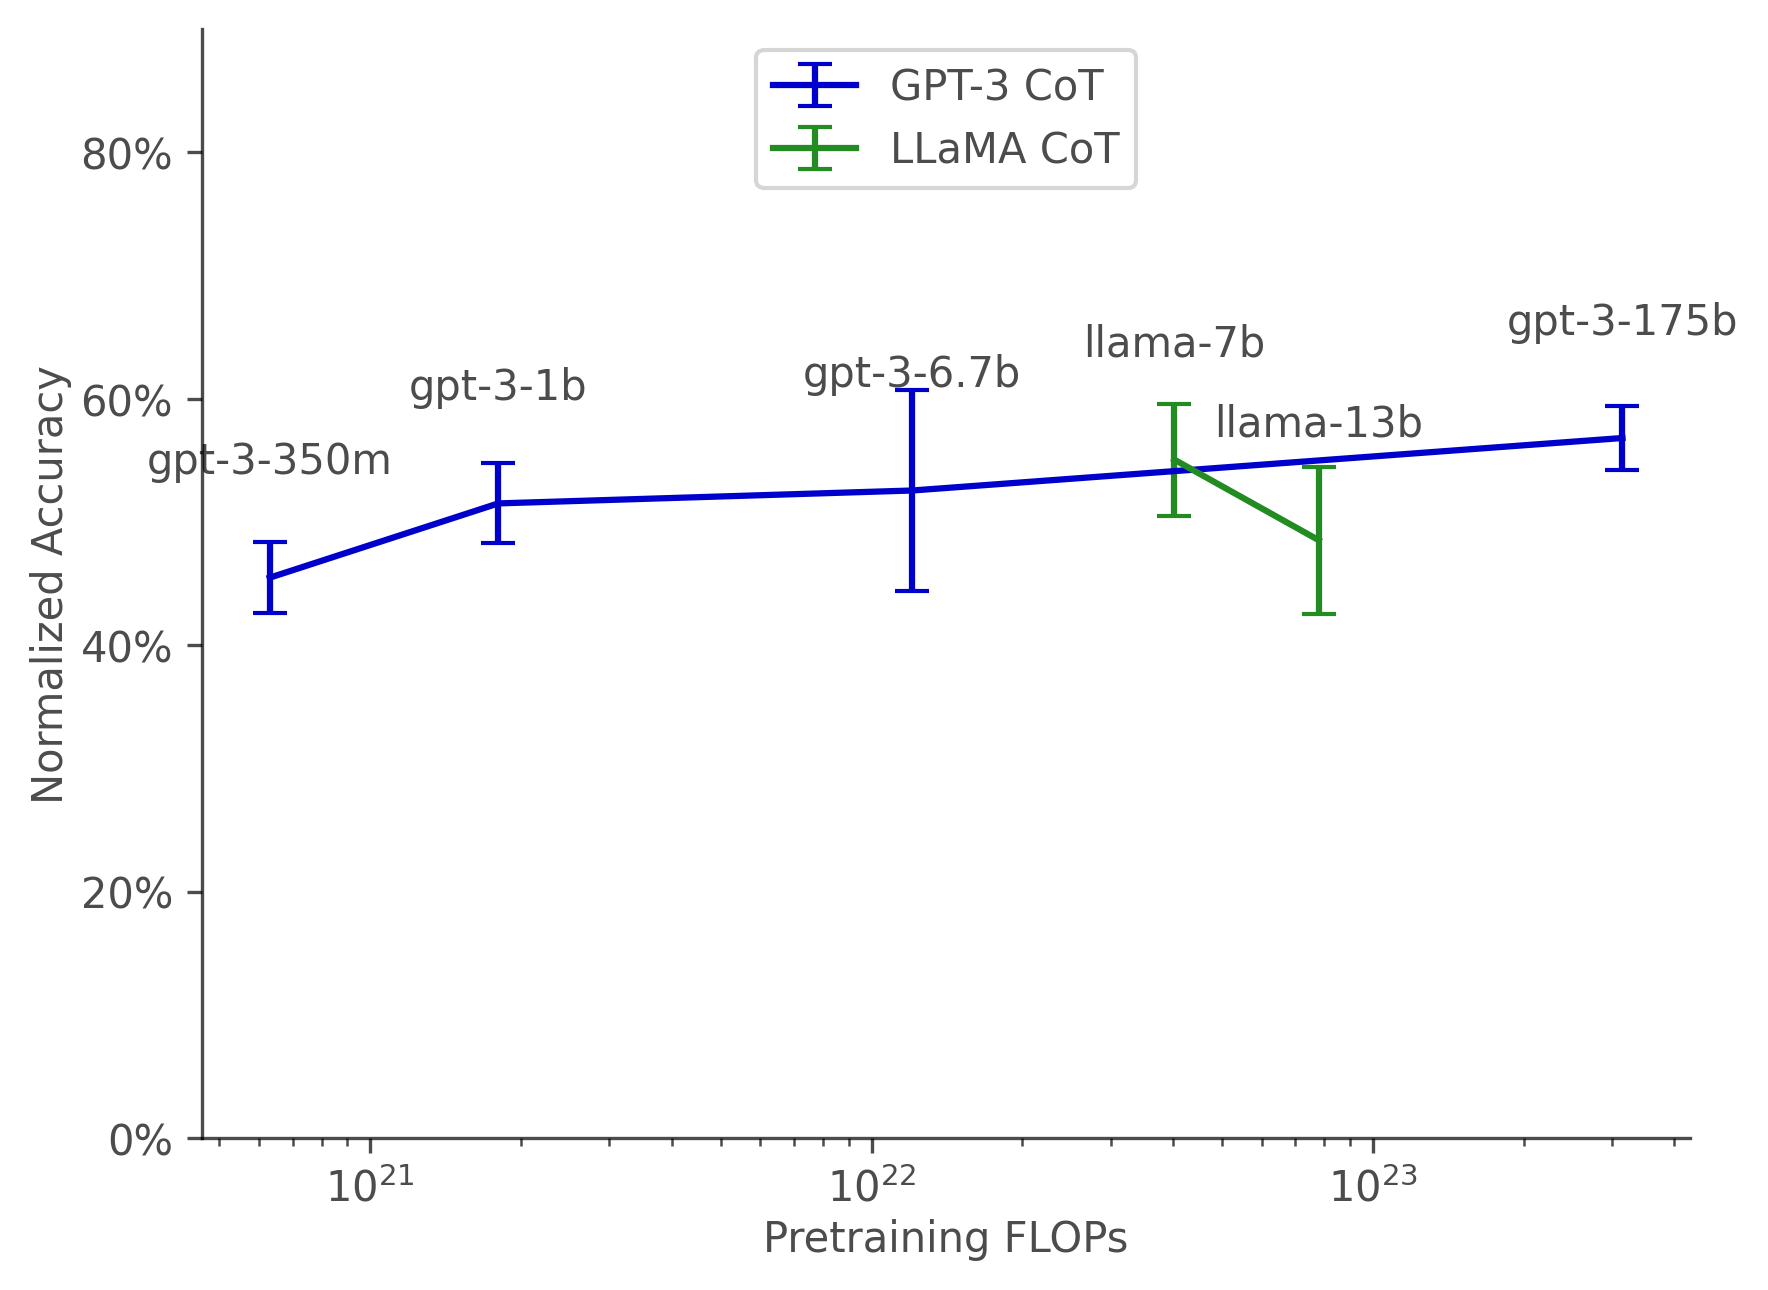

In [6]:
annotations = [GPT3_NAME_TO_MODEL_SIZE.values(), llama_data.annotations]
plot_errorbar(
    filename="scaling_normalized_cot.pdf",
    data=[gpt3_data, llama_data],
    labels=["GPT-3 CoT", "LLaMA CoT",],
    xlabel="Pretraining FLOPs",
    ylabel="Normalized Accuracy",
    annotations=annotations,
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                  load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar_cot.yaml")),
                                    {'non_rc_params': {'ylim': (0, 0.9)}}),
)

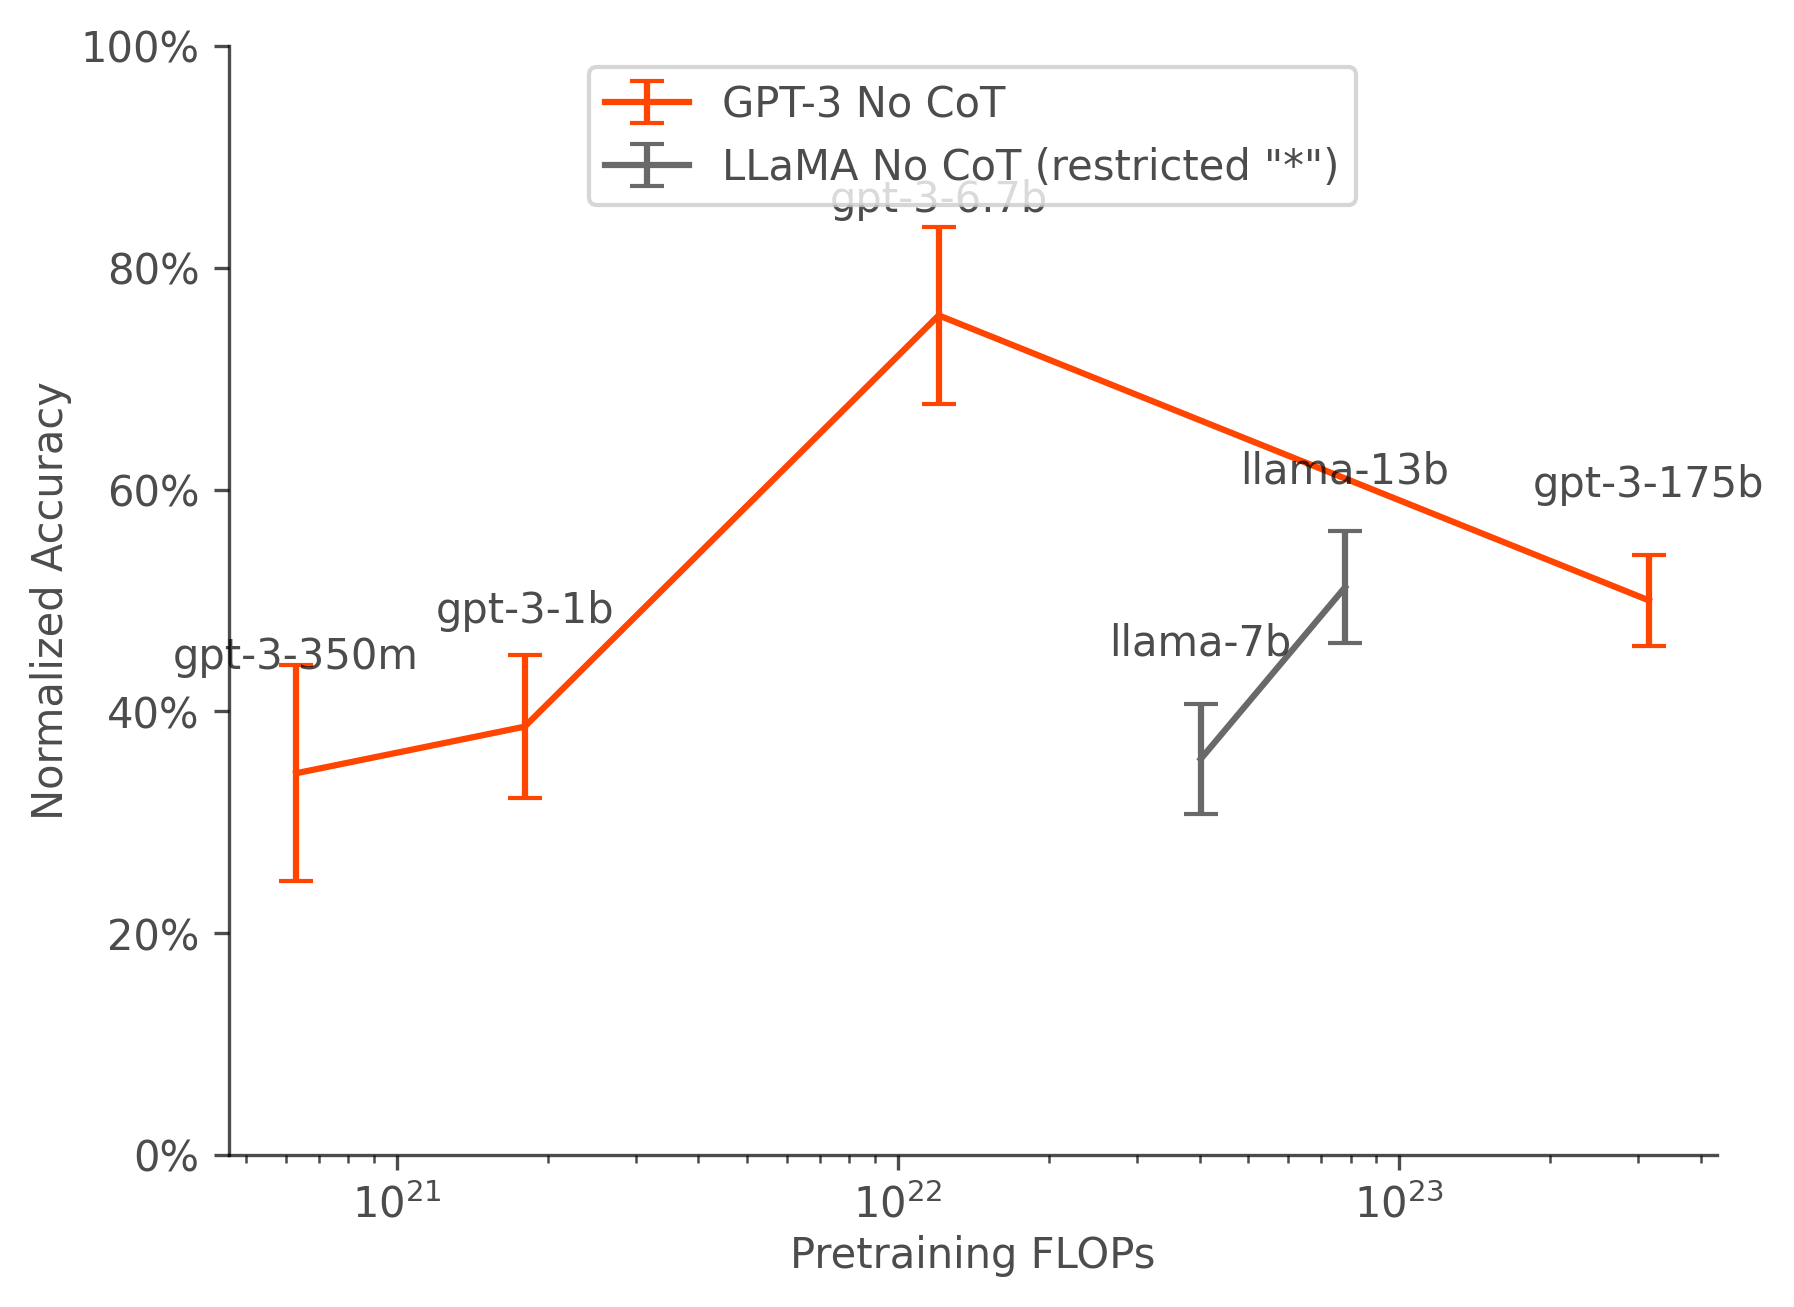

In [7]:
plot_errorbar(
    filename="scaling_normalized_no_cot.pdf",
    data=[gpt3_no_cot_data, llama_no_cot_data],
    labels=["GPT-3 No CoT", "LLaMA No CoT (restricted \"*\")",],
    xlabel="Pretraining FLOPs",
    ylabel="Normalized Accuracy",
    annotations=annotations,
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                  load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar_no_cot.yaml")),
                                    {'non_rc_params': {'ylim': (0, 1.0)}}),
)

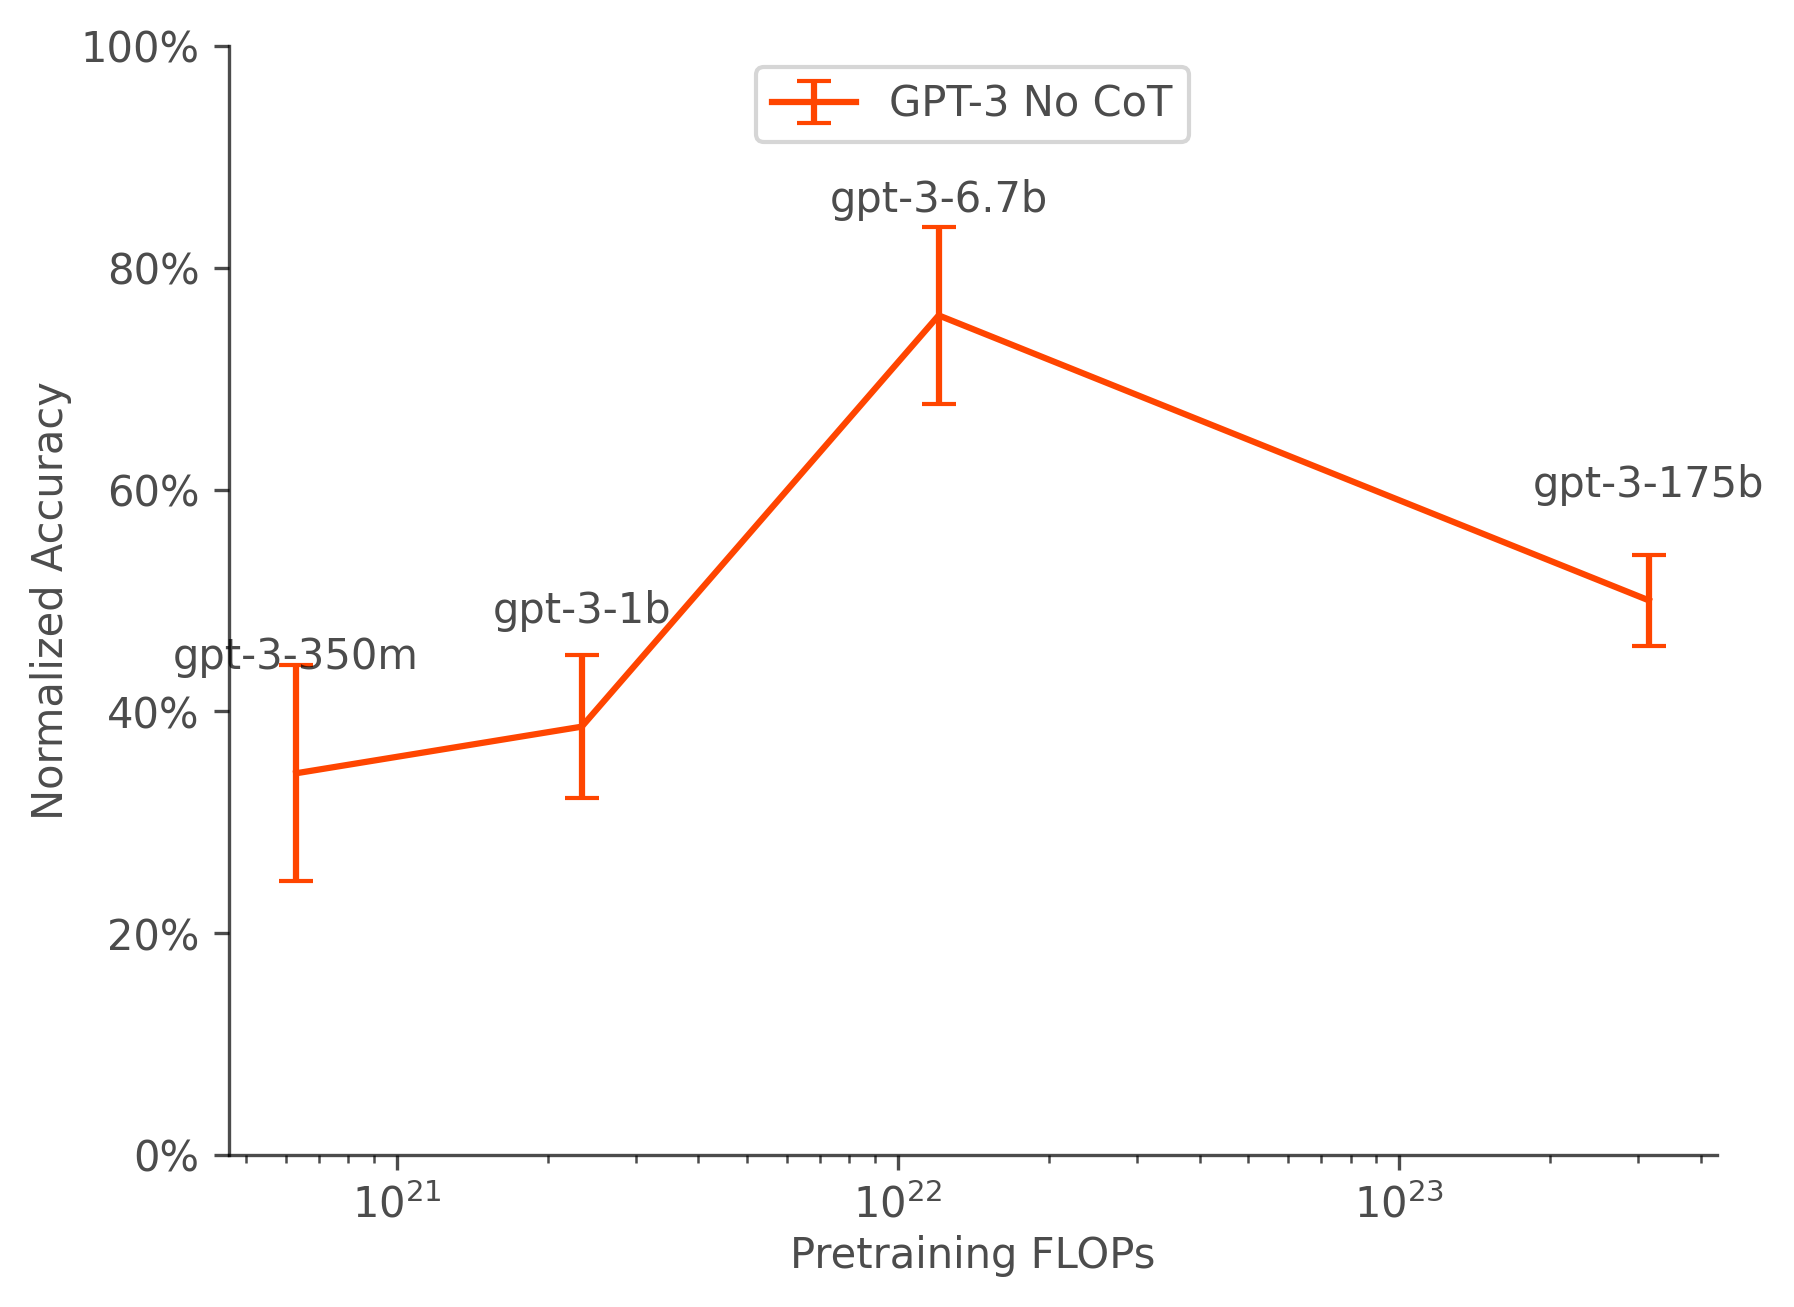

In [10]:
plot_errorbar(
    filename="scaling_normalized_no_cot_llama_excluded.pdf",
    data=[gpt3_no_cot_data],
    labels=["GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Normalized Accuracy",
    annotations=[GPT3_NAME_TO_MODEL_SIZE.values()],
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                  load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar_no_cot.yaml")),
                                    {'non_rc_params': {'ylim': (0, 1.0)}}),
)

## OC / IC for aliases

In [8]:
from scripts.assistant.plots.plot_utils import GPT3_MODELS, LLAMA_MODELS

# TODO cot vs no cot


gpt3_alias_df = get_runs_df("sita/assistant-final-alias",
                            keys = ALIAS_TASK_ACCURACIES + ALIAS_NO_COT_TASK_ACCURACIES)
llama_alias_df = get_runs_df("asacoopstick/assistant-final-alias-opensource",
                             keys = ALIAS_OPENSOURCE_TASK_ACCURACIES + ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES)
llama_alias_df = llama_alias_df[llama_alias_df["eval/ue_no_cot_sentiment53_accuracy"] != -1]                             
gpt3_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None), 
                                        columns=ALIAS_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2,owt=None),
                                               columns=ALIAS_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
llama_alias_data: ErrorBarData = PlotData(filter_df(llama_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None),
                                          columns=ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")

llama_alias_data.set_annotations_to_x()
gpt3_alias_data.set_annotations_to_x()
gpt3_no_cot_alias_data.set_annotations_to_x()


gpt3_alias_data.x = [model_to_flops(str(model)) for model in gpt3_alias_data.x]
gpt3_no_cot_alias_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_alias_data.x]
llama_alias_data.x = [model_to_flops(str(model)) for model in llama_alias_data.x]

normalized_gpt3_alias_data = normalize_by_in_context_scores(gpt3_alias_data, in_context_accuracies).sort_by_x()
normalized_gpt3_no_cot_alias_data = normalize_by_in_context_scores(gpt3_no_cot_alias_data, in_context_accuracies).sort_by_x()
normalized_llama_alias_data = normalize_by_in_context_scores(llama_alias_data, in_context_accuracies).sort_by_x()


plot_errorbar(
    filename="scaling_alias_normalized.pdf",
    data=[normalized_llama_alias_data, normalized_gpt3_no_cot_alias_data],
    labels=["LLaMA no CoT", "GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Normalized Accuracy",
    annotations=[["llama-7b", "llama-13b", "llama-30b"], 
                 [GPT3_NAME_TO_MODEL_SIZE["ada"], GPT3_NAME_TO_MODEL_SIZE["babbage"], GPT3_NAME_TO_MODEL_SIZE["curie"], GPT3_NAME_TO_MODEL_SIZE["davinci"]]],
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                  load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar_no_cot.yaml")),
                                    {'non_rc_params': {'ylim': (0, 0.3), 'yaxis.major_locator': 0.1}}),
    # preset_override="seaborn-colorblind"
)

# bar plot of per task in context accuracy for a given model

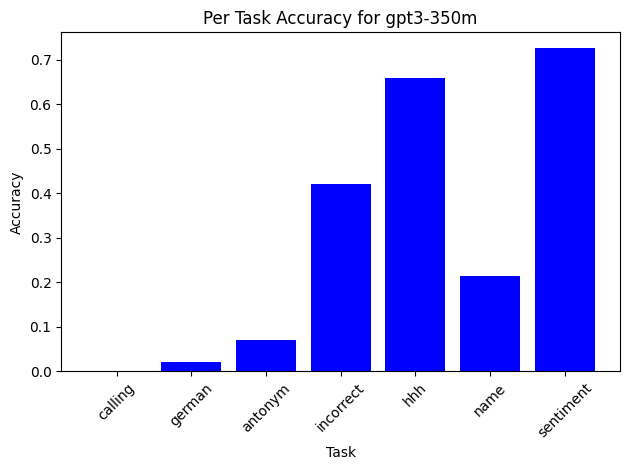

In [16]:
# bar plot of per task in context accuracy for a given model
models = ['ada', 'curie', 'llama-13b', 'llama-7b', 'davinci', 'babbage',
       'llama-30b', 'EleutherAI/pythia-70m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-70m']

model = "ada"
df = in_context_df[in_context_df["model"] == model]
model_descriptor = GPT3_NAME_TO_MODEL_SIZE[model] if model in GPT3_NAME_TO_MODEL_SIZE else model

# make barplot
plt.bar(x=df["task"], height=df["accuracy"], color="blue")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.xlabel("Task")
plt.title(f"Per Task Accuracy for {model_descriptor}")
plt.tight_layout()

# display
plt.show()

# save
plt.savefig(f"per_task_in_context_accuracy_{model_descriptor}.pdf")
plt.close()


In [15]:
in_context_df['model'].unique()

array(['ada', 'curie', 'llama-13b', 'llama-7b', 'davinci', 'babbage',
       'llama-30b', 'EleutherAI/pythia-70m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-70m'], dtype=object)

## Natural instructions plots

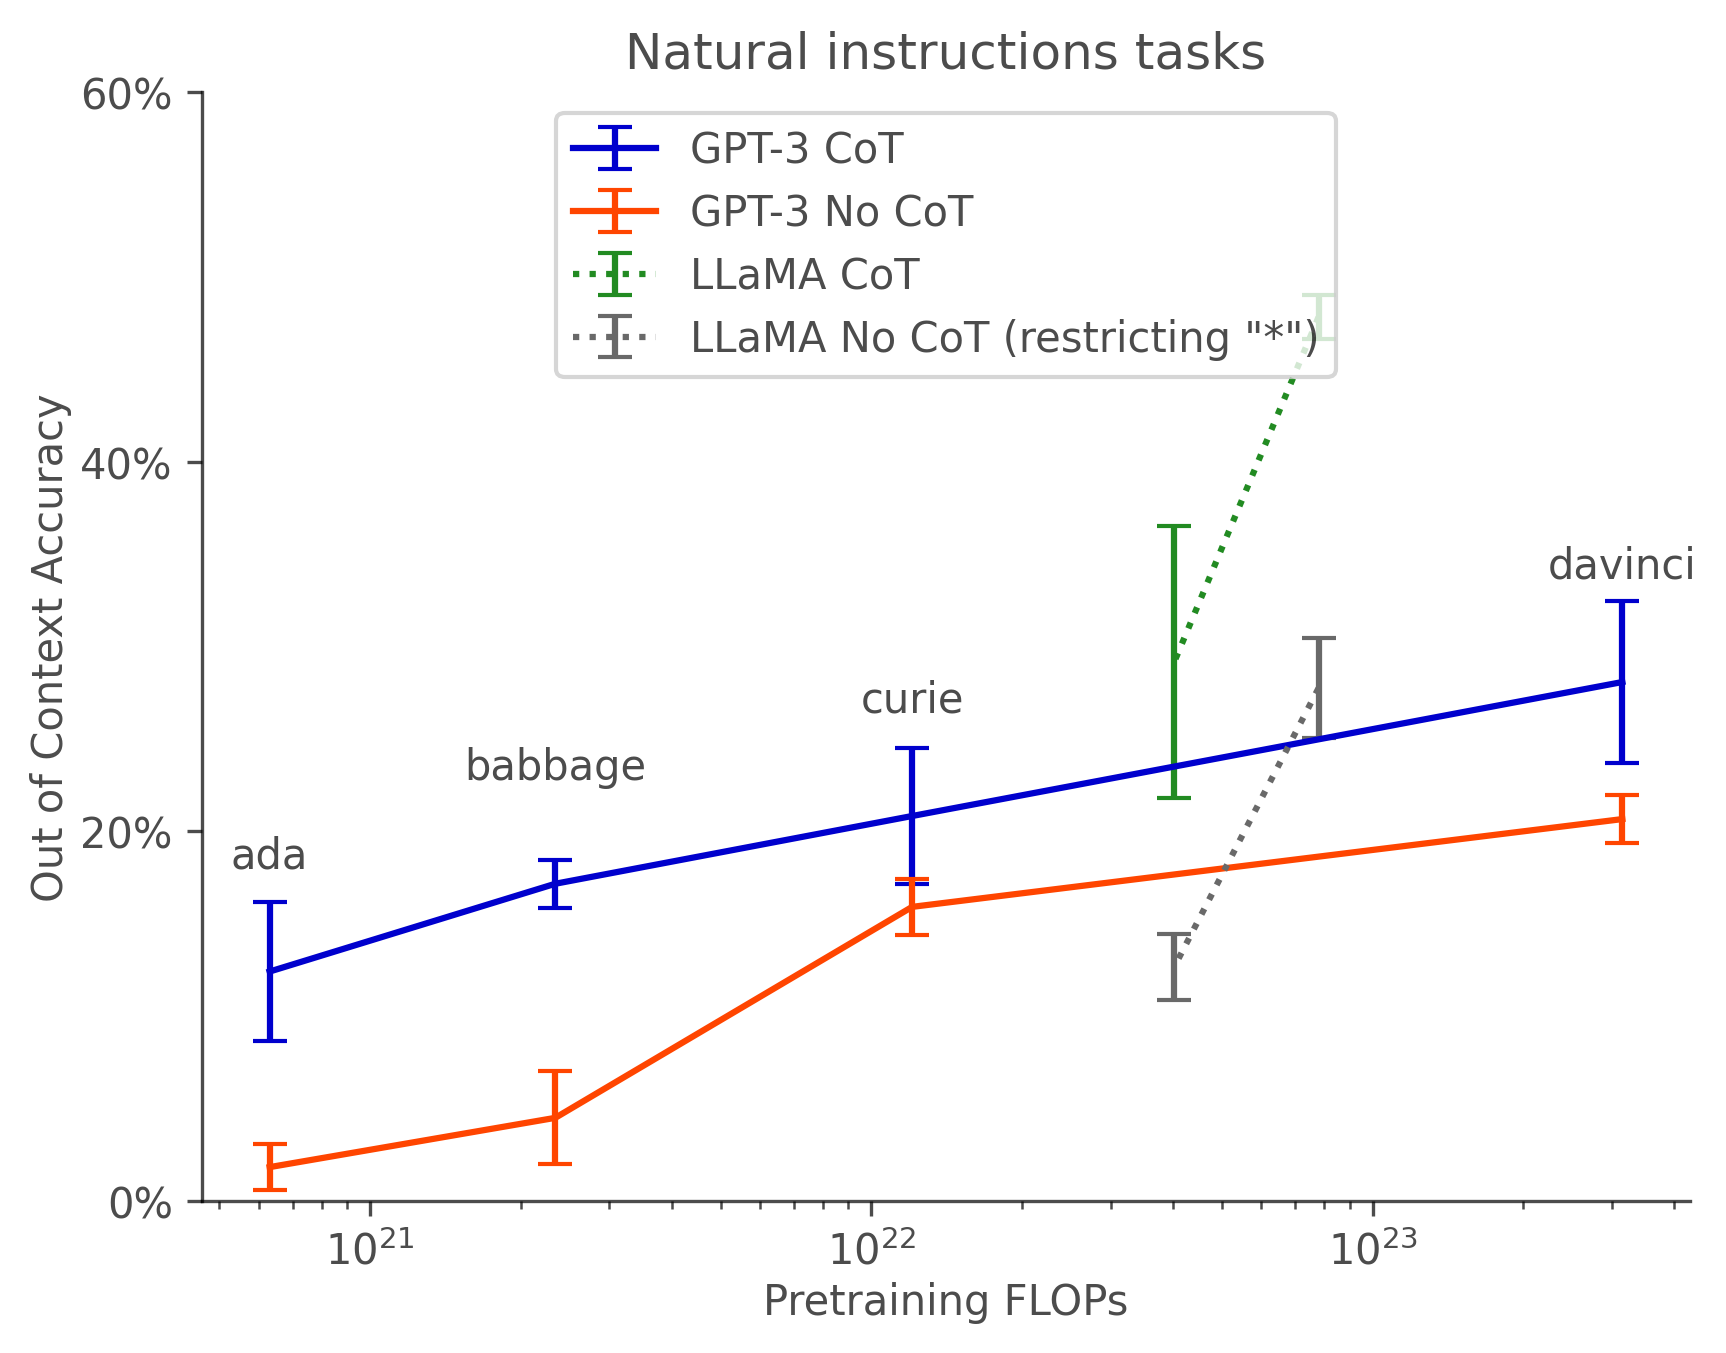

In [19]:
gpt3_df = get_runs_df("sita/assistant-ni-final", keys=NATURAL_INSTRUCTIONS_TASK_ACCURACIES+NATURAL_INSTRUCTIONS_NO_COT_TASK_ACCURACIES)
gpt3_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=NATURAL_INSTRUCTIONS_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=NATURAL_INSTRUCTIONS_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_data.x = [model_to_flops(str(model)) for model in gpt3_data.x]
gpt3_no_cot_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_data.x]
 
llama_df = get_runs_df("sita/assistant-opensource-ni-final", keys=NATURAL_INSTRUCTIONS_TASK_ACCURACIES+NATURAL_INSTRUCTIONS_NO_COT_TASK_ACCURACIES)
llama_data: ErrorBarData = PlotData(filter_df(llama_df, model=None), columns=NATURAL_INSTRUCTIONS_TASK_ACCURACIES).get_errorbar_data("model")
llama_no_cot_data: ErrorBarData = PlotData(filter_df(llama_df, model=None), columns=NATURAL_INSTRUCTIONS_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
llama_data.x = [model_to_flops(str(model)) for model in llama_data.x]
llama_no_cot_data.x = [model_to_flops(str(model)) for model in llama_no_cot_data.x]

plot_errorbar(
    filename="scaling.pdf",
    title='Natural instructions tasks',
    data=[gpt3_data, gpt3_no_cot_data, llama_data, llama_no_cot_data],
    labels=["GPT-3 CoT", "GPT-3 No CoT", "LLaMA CoT", "LLaMA No CoT (restricting \"*\")"], 
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    annotations=[["ada", "babbage", "curie", "davinci"], ["", "", "", ""], None, None],
    config_override=load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml"))
)

## Augmentation fraction

/var/folders/ht/7btfb45n7wv05ckkx3nvng740000gn/T/ipykernel_93346/2717834944.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  augmentation_df = filter_df(df)[df["Notes"].apply(lambda x: "e=1" in x)]


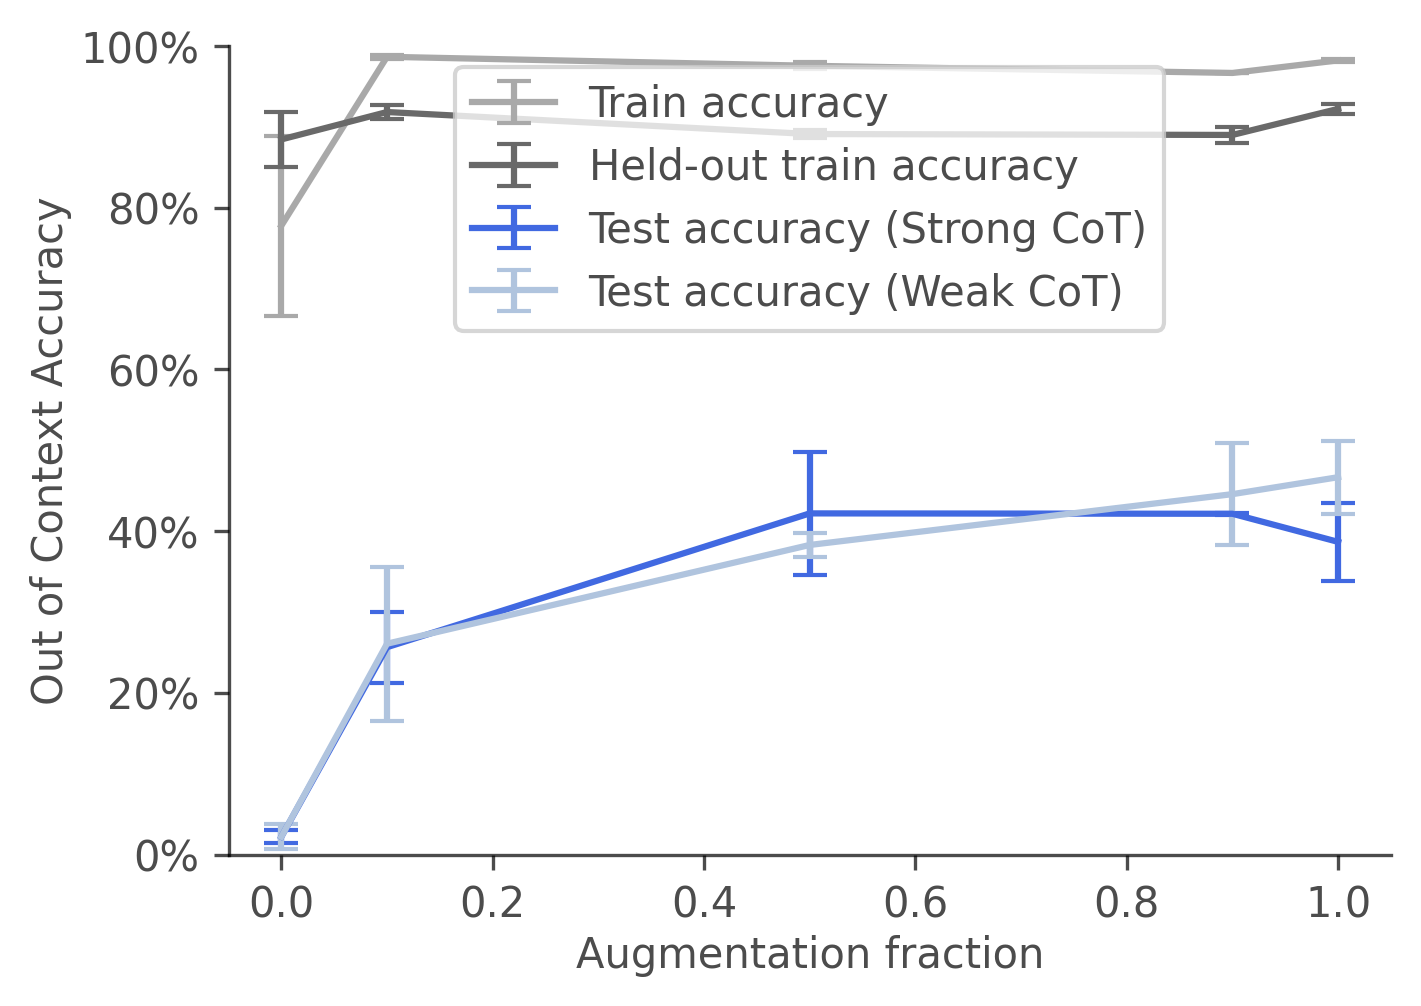

In [17]:
df = get_runs_df("sita/assistant-augmentation", keys=ACCURACIES)
augmentation_df = filter_df(df)[df["Notes"].apply(lambda x: "e=1" in x)]
augmentation_df["augmentation_fraction"] = augmentation_df["Notes"].apply(lambda x: float(x.split(",")[0].split("=")[1]))

data: List[ErrorBarData] = [PlotData(filter_df(augmentation_df), columns=[accuracy]).get_errorbar_data("augmentation_fraction") for accuracy in ACCURACIES]
# data: ErrorBarData = PlotData(filter_df(augmentation_df), columns=["test_accuracy"]).get_errorbar_data("augmentation_fraction")
# augmentation_no_cot_data: ErrorBarData = PlotData(filter_df(df), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("num_rg")
plot_errorbar(
    data=data,
    labels=["Train accuracy", "Held-out train accuracy", "Test accuracy (Strong CoT)", "Test accuracy (Weak CoT)"],
    xlabel="Augmentation fraction",
    ylabel="Out of Context Accuracy",
    config_override={'rc_params': {'figure.figsize': [5, 3.5], 
                                   'axes.prop_cycle': {'color': ["darkgrey", "dimgrey", "royalblue", "lightsteelblue"]}},
                     'non_rc_params': {'ylim': (0, 1.0)}}
)